In [65]:
# Tokenazation example with 'Kupfer, blank I, Millberry'
import spacy
import spacy_transformers
import de_dep_news_trf
import en_core_web_sm

# Load the en_core_web_sm model
de_nlp = spacy.load('de_dep_news_trf')

# Load the en_core_web_sm model
en_nlp = spacy.load('en_core_web_sm')

# Create a Doc object for testing
doc = de_nlp('Kupfer, blank I, Millberry')

# Generate the tokens
tokens = [token.text for token in doc]

# Print results
print(tokens)

['Kupfer', ',', 'blank', 'I', ',', 'Millberry']


In [66]:
import pandas as pd

# Import data
opportunity_descriptions = pd.read_csv('../data_git/opportunity_descriptions.csv')
materials = pd.read_csv('../data_git/materials.csv')
materials_desc = pd.read_csv('../data_git/material_desc.csv')
material_aliases = pd.read_csv('../data_git/material_aliases.csv')

# Rename and select columns
materials = materials[['product_id', 'material_name']]
materials.rename(columns={'material_name': 'text'}, inplace=True)
opportunity_descriptions.rename(columns={'txt_material_comments_seller': 'text', 'cd_product_id':'product_id'}, inplace=True)
materials_desc.rename(columns={'description': 'text', 'cd_product_id':'product_id'}, inplace=True)
material_aliases = material_aliases[['ds_material_alias', 'cd_product_id']]
material_aliases.rename(columns={'ds_material_alias': 'text', 'cd_product_id':'product_id'}, inplace=True)

# Concatenate dataframes
material_text = pd.concat([materials, opportunity_descriptions, materials_desc, material_aliases])

# Drop any na values
material_text.dropna(inplace=True)

# Drop any text duplicates
material_text.drop_duplicates(subset='text', inplace=True)

# Show the first rows
material_text.head()

,product_id,text
0,10066.0,"Edelstahl, V2A Schrott, unrein"
1,10134.0,"Zinn, unrein"
2,10063.0,Alu-Riffelblech
3,10083.0,Nickel-Legierung
4,10241.0,Kupfer-Späne unrein


<Axes: >

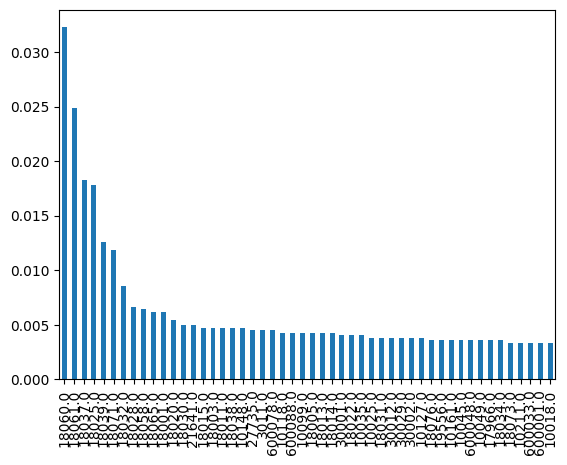

In [67]:
material_text['product_id'].value_counts(normalize = True).head(50).plot.bar()

## Tokenization

The next step is to tokenize our data. Tokenization is the process of separating our text into tokens, which can be defined as one or multiple units. There are several techniques to do this. These are the steps we are going to take in preprocessing:

1. Converting words into lowercase
2. Removing leading and trailing whitespaces
3. Converting words into lemmas
4. Removing punctuation
5. Removing stopwords
6. Expanding contractions
7. Removing special characters

Note that most of our text is in German. Therefore, we need to leverage the parameters of the [spaCy documentation](https://spacy.io/usage/models)
Because of this, we will need an algorithm to determine in what language the text is (or is likely to be) to perform the best possible tokenization.

_Note, after loading the spacy package you might need to reboot your computer (the first time). If you are getting this error:_
> ValueError: [E002] Can't find factory for 'transformer' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a Transformer, make sure to install 'spacy-transformers'. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

In [68]:
# Importing the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X = material_text['text']  # Features
y = material_text['product_id']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Converting the text to numerical features:

In [69]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()  # Adjust max_features as needed

# Fit and transform the training data and transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [70]:
# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [71]:
# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.18861209964412812
Classification Report:
               precision    recall  f1-score   support

      3010.0       1.00      1.00      1.00         2
      3011.0       0.00      0.00      0.00         8
      4060.0       0.00      0.00      0.00         1
     10002.0       0.00      0.00      0.00         1
     10003.0       0.00      0.00      0.00         2
     10005.0       0.00      0.00      0.00         3
     10010.0       0.00      0.00      0.00         2
     10016.0       0.00      0.00      0.00         4
     10017.0       0.00      0.00      0.00         2
     10018.0       0.50      0.50      0.50         2
     10019.0       0.00      0.00      0.00         2
     10021.0       0.00      0.00      0.00         3
     10024.0       0.00      0.00      0.00         1
     10025.0       1.00      0.17      0.29         6
     10027.0       0.00      0.00      0.00         2
     10031.0       1.00      0.50      0.67         2
     10034.0       0.00    

/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bernardocarvalho/Desktop/imperial_repos/work_based_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

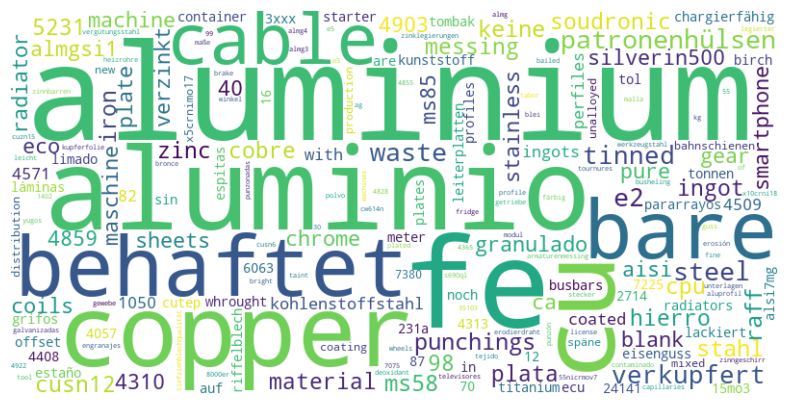

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients of the model for each class (you can average them if you have multiple classes)
coefficients = model.coef_.mean(axis=0)

# Create a dictionary of words and their importance
word_importance = {feature_names[i]: coefficients[i] for i in range(len(feature_names))}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importance)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

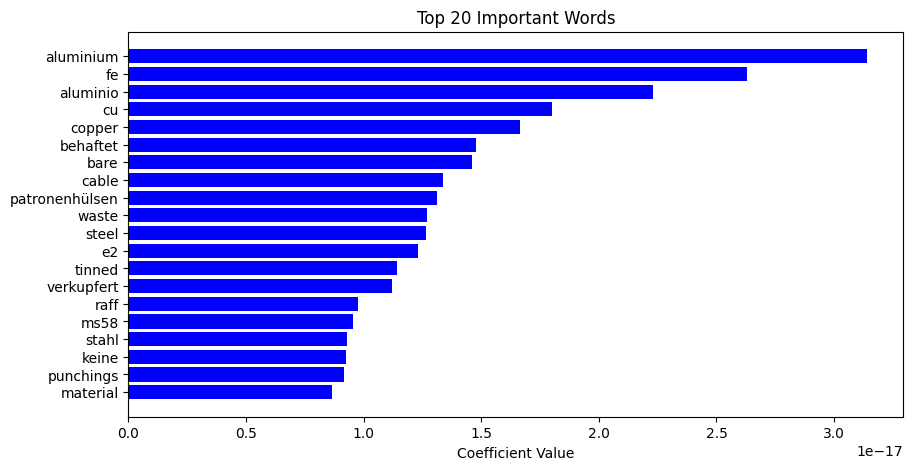

In [73]:
import numpy as np

# Sort the words by their importance (absolute value of the coefficients)
sorted_indices = np.argsort(coefficients)[::-1]
top_n = 20  # Number of top words to show
top_words = [feature_names[i] for i in sorted_indices[:top_n]]
top_coefficients = coefficients[sorted_indices[:top_n]]

# Plot the top words
plt.figure(figsize=(10, 5))
plt.barh(top_words, top_coefficients, color='blue')
plt.xlabel("Coefficient Value")
plt.title(f"Top {top_n} Important Words")
plt.gca().invert_yaxis()
plt.show()

In [74]:
# Initialize TF-IDF Vectorizer with n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # You can adjust n-gram range

# Fit and transform the data again
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Get german default stopwords
de_stopwords  = spacy.lang.de.stop_words.STOP_WORDS

# Get english default stopwords
en_stopwords = spacy.lang.en.stop_words.STOP_WORDS

At this step, we will apply a preprocessing step that converts words to lemmas. Lemmas are a basic form of a word that removes inflexions and therefore decreases variance. For example, the lemma for a verb is its infinitive form.


In [ ]:
uninteresting_char = set([',', '(', ')', 'und'])

def preprocess(text, language='en'):
    # Create Doc object
        if language == 'de':
                doc = de_nlp(text, disable=['ner', 'parser'])
                stopwords = de_stopwords
        else:
                doc = en_nlp(text, disable=['ner', 'parser'])
                stopwords = en_stopwords
        lemmas = [token.lemma_ for token in doc]
        # Remove stopwords and non-alphabetic characters
        a_lemmas = [lemma for lemma in lemmas 
                if lemma not in stopwords
                and lemma not in uninteresting_char]
        return ' '.join(a_lemmas)

# Apply preprocess to the mateirial alias given the language
df1['p_ds_material_alias'] = df1.apply(lambda x: preprocess(x['ds_material_alias'], x['cd_alias_language']), axis=1)

In [ ]:
# Plot top 50 words frequencies
import matplotlib.pyplot as plt

# Sum the frequencies of each word
word_freq = bow_df.sum()

# Plot the top 50 words
word_freq.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15, 7))
plt.title('Top 50 words frequencies')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.show()


In [ ]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(ted)

# Print the shape of tfidf_matrix
print(tfidf_matrix.shape)

## Calculating the cosine similarity

# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

In [ ]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english')

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(transcripts)

# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix1)

# Generate mapping between titles and index
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

def get_recommendations(title, cosine_sim, indices):
    # Get index of movie that matches title
    idx = indices[title]
    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

We should create word embeddings for the different forms of metals. For instance:
Kupfer, Copper, Cu should all be the same concept. --> Would increase the performance of the model without the need of so much data

# Import train_test_split

from sklearn.model_selection import train_test_split

X = material_desc_df.drop('product_id', axis=1)
y = material_desc_df['product_id']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Get cart_items
materials = pd.read_csv('data_git/material_aliases.csv')

materials['cd_product_id']

In [ ]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer()

# Corpus
corpus = material_desc_df['text'].to_list()

# Material to test
material = 'Copper milb'

# Add new material to corpus
corpus.append(material)
# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(corpus)
# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

# Get scores of the last material
sim_scores = list(enumerate(cosine_sim[-1]))

# Sort the materials based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Get the scores for 10 most similar materials
sim_scores = sim_scores[1:11]

# Get the material indices
material_indices = [i[0] for i in sim_scores]

# Return the top 10 most similar materials
top_n_scores = material_desc_df['product_id'].iloc[material_indices]

# Create DataFrame with top 10 most similar materials and their scores
top_n_scores_df = pd.DataFrame({'product_id': top_n_scores, 'similarity_score': [i[1] for i in sim_scores]})

# Merge with materials DataFrame to get material details
result = pd.merge(top_n_scores_df, materials, on='product_id')

result

In [ ]:
path = os.path.join(os.getcwd(), "data/")

# Load the data
materials = pd.read_csv(path + 'materials.csv')
material_desc_df = pd.read_csv(path + 'material_desc.csv')

# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer()

# Corpus
corpus = material_desc_df['text'].to_list()

# Material to test
material = 'Copper milb'

# Add new material to corpus
corpus.append(material)
# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(corpus)
# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

# Get scores of the last material
sim_scores = list(enumerate(cosine_sim[-1]))

# Sort the materials based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Get the scores for 10 most similar materials
sim_scores = sim_scores[1:11]

# Get the material indices
material_indices = [i[0] for i in sim_scores]

# Return the top 10 most similar materials
top_n_scores = material_desc_df['product_id'].iloc[material_indices]

# Create DataFrame with top 10 most similar materials and their scores
top_n_scores_df = pd.DataFrame({'product_id': top_n_scores, 'similarity_score': [i[1] for i in sim_scores]})

# Merge with materials DataFrame to get material details
result = pd.merge(top_n_scores_df, materials, on='product_id')

result